In [1]:
import sys
import os
import torch
sys.path.append('../..')
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from src.utils import load, load_checkpoint
from src.training.resnet_inception import create_dataloaders,create_network,Config
from src.models import InceptionResNetV2
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,auc,roc_curve
from torch.utils.data import DataLoader
from definitions import *

In [2]:
EXPIREMENT_NAME = 'resnet_inception'
EXPIREMENT_PATH = os.path.join(EXPIREMENTS_DIR,EXPIREMENT_NAME)
CHECKPOINTS_PATH = os.path.join(EXPIREMENT_PATH,'checkpoints')
CONFIG_PATH = os.path.join(EXPIREMENT_PATH,'config.json')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
config = Config(**load(CONFIG_PATH))
train_loader,val_loader = create_dataloaders(config)
model = create_network(config)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/inception_resnet_v2.tf_in1k)
INFO:timm.models._hub:[timm/inception_resnet_v2.tf_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [4]:
checkpoint = load_checkpoint(CHECKPOINTS_PATH)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [5]:
model = model.to(DEVICE)

In [6]:
def predict(model: InceptionResNetV2, dataloader: DataLoader):

    model.eval()

    y_true = []
    y_pred = []

    with torch.inference_mode():

        for x,y in tqdm(dataloader):

            x = x.to(DEVICE)
            y_hat = model.predict(x).detach().cpu().numpy()

            y_true.extend(y.numpy())
            y_pred.extend(y_hat)

    return y_true,y_pred

In [7]:
y_true,y_pred = predict(model,val_loader)

  0%|          | 0/3760 [00:00<?, ?it/s]

In [8]:
def calculate_metrics(y_true,y_pred):

    accuracy = accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred)
    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)

    return accuracy,f1,precision,recall

In [9]:
y_hard = [1 if y > 0.5 else 0 for y in y_pred]

In [10]:
calculate_metrics(y_true,y_hard)

(0.9200452135175119,
 0.021164021164021163,
 0.010719439290867862,
 0.8253968253968254)

<Axes: >

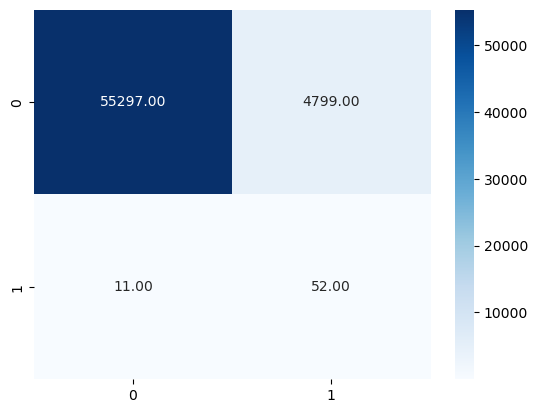

In [11]:
cm = confusion_matrix(y_true,y_hard)
sns.heatmap(cm,annot=True,cmap='Blues',fmt='.2f')

In [12]:
def score(solution: np.array, submission: np.array, min_tpr : float = 0.8) -> float:
    v_gt = abs(np.asarray(solution)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    
    return(partial_auc)

In [13]:
score(np.array(y_true),np.array(y_pred))

0.16033927726220054